# The Use of Machine Learning in Treatment Effect Estimation

In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from econml.dml import DML
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text  # Add export_text import
import matplotlib.pyplot as plt

#### $Y(1)$ is the potential outcome under treatment 
#### $Y(0)$ is the potential outcome under no treatment. 
#### These are associated with the binary treatment $D \:\epsilon\: \{0,1\}$ 
#### let $X$ stand for the vector of predetermined covariates. 

In [10]:
# Step 1: Simulate Data with Treatment Effect Heterogeneity
np.random.seed(123)
n = 1000
X = np.random.normal(0, 1, (n, 3))  # Covariates
T = np.random.binomial(1, 0.5, n)   # Binary Treatment
# Outcome with heterogenous treatment effect
Y = 2*T*X[:, 0] + X[:, 1] + np.random.normal(0, 1, n)

In [11]:
# Step 2: Split the data into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

In [12]:
# Step 3: Define machine learning models for Y and T
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

In [19]:
# Step 4: Initialize Double Machine Learning (DML) estimator
# Modify LinearRegression to not fit an intercept
dml_estimator = DML(
    model_y=model_y, 
    model_t=model_t, 
    model_final=LinearRegression(fit_intercept=False),  # Disable intercept in final model
    discrete_treatment=True)

# Fit the DML estimator to the training data
dml_estimator.fit(Y_train, T_train, X=X_train)

In [20]:
# Step 5: Average Treatment Effect (ATE) Estimation
# Estimate the ATE across all test samples
ate = dml_estimator.effect(X_test)
print(f"Average Treatment Effect (ATE): {np.mean(ate)}")

Average Treatment Effect (ATE): -0.35664078029578705


Conditional Average Treatment Effects (CATE) for test samples: 
[-3.08549298 -3.1941603   1.7404985   0.62244308  0.81657591]


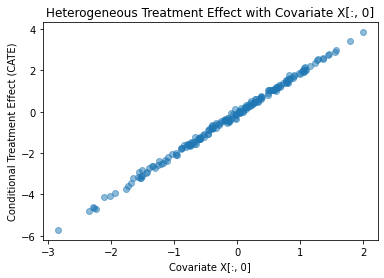

In [21]:
# Step 6: Conditional Average Treatment Effect (CATE) Estimation
# Estimate treatment effects conditional on covariates (CATE)
cate = dml_estimator.effect(X_test)

# Print CATEs for first few test samples
print(f"Conditional Average Treatment Effects (CATE) for test samples: \n{cate[:5]}")

# Optional: Visualizing treatment effect heterogeneity across covariate X[:, 0]
plt.scatter(X_test[:, 0], cate, alpha=0.5)
plt.xlabel('Covariate X[:, 0]')
plt.ylabel('Conditional Treatment Effect (CATE)')
plt.title('Heterogeneous Treatment Effect with Covariate X[:, 0]')
plt.show()

In [22]:
# Step 7: Check treatment effect heterogeneity in a more structured way (optional)
# Use DecisionTreeRegressor to uncover decision rules for CATE
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_test, cate)
tree_model_text = export_text(tree_model)
print(f"Decision rules from tree: \n{tree_model_text}")

Decision rules from tree: 
|--- feature_0 <= -0.34
|   |--- feature_0 <= -1.17
|   |   |--- feature_0 <= -1.74
|   |   |   |--- value: [-4.48]
|   |   |--- feature_0 >  -1.74
|   |   |   |--- value: [-2.92]
|   |--- feature_0 >  -1.17
|   |   |--- feature_0 <= -0.68
|   |   |   |--- value: [-1.78]
|   |   |--- feature_0 >  -0.68
|   |   |   |--- value: [-1.06]
|--- feature_0 >  -0.34
|   |--- feature_0 <= 0.49
|   |   |--- feature_0 <= 0.11
|   |   |   |--- value: [-0.26]
|   |   |--- feature_0 >  0.11
|   |   |   |--- value: [0.47]
|   |--- feature_0 >  0.49
|   |   |--- feature_0 <= 1.06
|   |   |   |--- value: [1.41]
|   |   |--- feature_0 >  1.06
|   |   |   |--- value: [2.61]

